In [ ]:
# Rahul Patil 20230901013
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import os
import pprint
from collections import Counter
import joblib
from pprint import pprint
import cv2

# skimage libraries
from skimage.io import imread
from skimage.transform import resize
#from skimage.feature import hog
from skimage.transform import rescale

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [5]:
# helper function - resize image from CHATgpt For data resizing
def resize_all(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})mini dog images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(f"Reading images for {subdir} ...")
            current_path = os.path.join(src, subdir)
        
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [6]:
# parameters
IMAGE_PATH = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold1\Train"
CLASSES = os.listdir(IMAGE_PATH)
BASE_NAME = 'Skin_Lision_Mpox'
WIDTH = 90
# load & resize the images
resize_all(src=IMAGE_PATH, pklname=BASE_NAME, width=WIDTH, include=CLASSES)

Reading images for Chickenpox ...
Reading images for Cowpox ...
Reading images for Healthy ...
Reading images for HFMD ...
Reading images for Measles ...
Reading images for Monkeypox ...


In [7]:
# read from the pickle/dictionary
data = joblib.load(f'{BASE_NAME}_{WIDTH}x{WIDTH}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  537
keys:  ['description', 'label', 'filename', 'data']
description:  resized (90x90)mini dog images in rgb
image shape:  (90, 90, 3)
labels: ['Chickenpox' 'Cowpox' 'HFMD' 'Healthy' 'Measles' 'Monkeypox']


Counter({'Monkeypox': 202,
         'HFMD': 116,
         'Healthy': 83,
         'Chickenpox': 50,
         'Cowpox': 49,
         'Measles': 37})

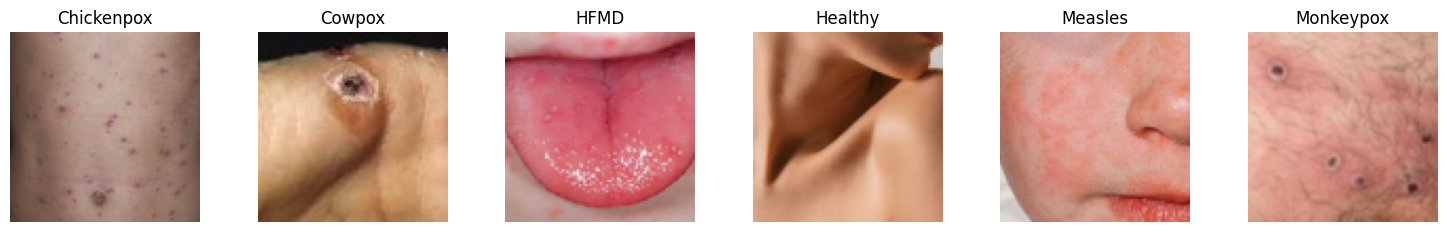

In [8]:
# display images
labels = np.unique(data['label'])
 
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [9]:
# feature engineering
x = np.array(data['data'])
y = np.array(data['label'])

# split - train & validation
SIZE = 0.1 
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=SIZE,shuffle=True,random_state= np.random.randint(1,50),)

# view
print(f"Training Size: {x_train.shape[0]}\n Validation Size: {x_test.shape[0]}")

Training Size: 483
 Validation Size: 54


In [10]:
# normalisation
x_train = x_train/255.0
x_test = x_test/255.0

# reshape the array (4d to 2d)
nsamples, nx, ny, nrgb = x_train.shape
x_train2 = x_train.reshape((nsamples,nx*ny*nrgb))

nsamples, nx, ny, nrgb = x_test.shape
x_test2 = x_test.reshape((nsamples,nx*ny*nrgb))

In [11]:
# random forest classifier - baseline
rfc = RandomForestClassifier()

# fit
rfc.fit(x_train2,y_train)

# predict
y_pred = rfc.predict(x_test2)

# accuracy score
acc = '{:.1%}'.format(accuracy_score(y_test, y_pred))
print(f"Accuracy for Random Forrest: {acc}")

Accuracy for Random Forrest: 48.1%


In [12]:
# random forest classifier - hyperparameter tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 3)]

# Number of features to consider at every split
criterion = ['gini', 'entropy']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# class weight
class_weight = ['balanced', 'balanced_subsample', None]


# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight':class_weight}
             

print(param_grid)

{'n_estimators': [200, 600, 1000], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 60, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'class_weight': ['balanced', 'balanced_subsample', None]}


In [13]:
# baseline random forest classifier (for hyperparameter tuning)
rfc_t = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfc_t
                               ,param_distributions = param_grid
                               ,n_iter = 10
                               ,cv = 3
                               ,verbose=0
                               ,random_state=42
                               ,n_jobs = -1)

# Fit the random search model
rf_random.fit(x_train2,y_train)

# get the best params
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 60,
 'criterion': 'gini',
 'class_weight': None,
 'bootstrap': False}

In [14]:
# random forest classifier - tuned
rfc_t = rf_random.best_estimator_

# fit
rfc_t.fit(x_train2,y_train)

# predict
y_pred = rfc_t.predict(x_test2)

# accuracy score
acc = '{:.1%}'.format(accuracy_score(y_test, y_pred))
print(f"Accuracy for Random Forrest (tuned): {acc}")

Accuracy for Random Forrest (tuned): 46.3%


In [15]:
filename = 'Randomforest_Mpox.pkl'
joblib.dump(rfc_t, filename)

['Randomforest_Mpox.pkl']

In [22]:
loaded_model = joblib.load(filename)

In [16]:
# prediction on custom images

img_path1 = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold1\Test\Chickenpox\CHP_19_01.jpg"    # Chickenpox
img_path2 = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold1\Test\Healthy\HEALTHY_98_01.jpg" # Healthy
img_path3 = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold1\Test\Measles\MSL_23_01.jpg" # Measles
img_path4 = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold1\Test\Cowpox\CWP_09_01.jpg" # Cowpox

In [17]:
# custom function to predict label
def predict_label(path):
    
    # image read from path & resize
    img_arr = cv2.imread(path)
    img_arr = cv2.resize(img_arr,(WIDTH,WIDTH))
    
    # normalisation & re-shaping
    img_arr = img_arr / 255.0
    nx, ny, nrgb = img_arr.shape
    img_arr2 = img_arr.reshape(1,(nx*ny*nrgb))
    
    # prediction
    custom_pred = rfc_t.predict(img_arr2)
    
    # predict the label
    print(f"The predicted label for the custom image is: {custom_pred[0]}\n")
    
    # plot the image & predicted label
    fig, axes = plt.subplots(1, 1)
    fig.set_size_inches(5,5)
    fig.tight_layout()
    image = plt.imread(path)
    plt.imshow(image)
    plt.axis('off')
    plt.title("predicted label: " + custom_pred[0])

The predicted label for the custom image is: Healthy



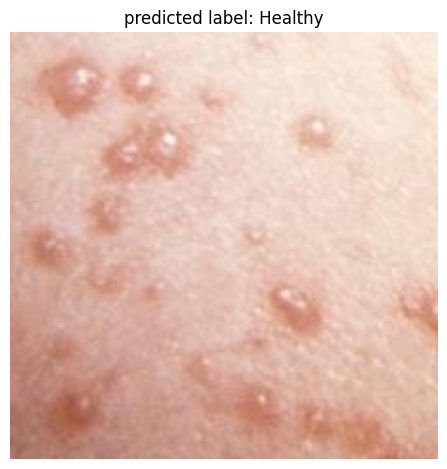

In [18]:
predict_label(img_path1)

The predicted label for the custom image is: Healthy



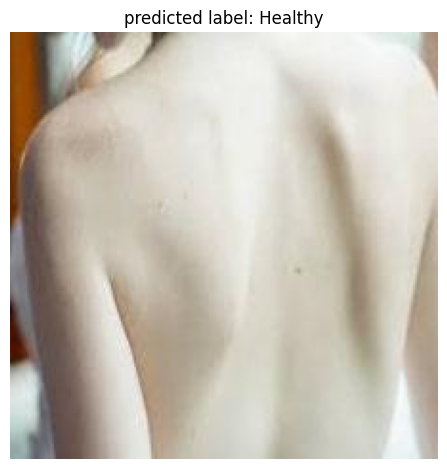

In [19]:
predict_label(img_path2)

The predicted label for the custom image is: Healthy



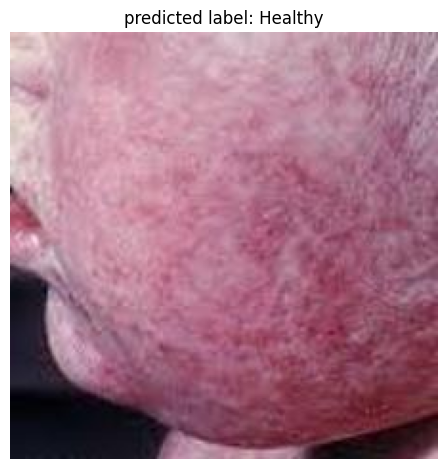

In [20]:
predict_label(img_path3)

The predicted label for the custom image is: Healthy



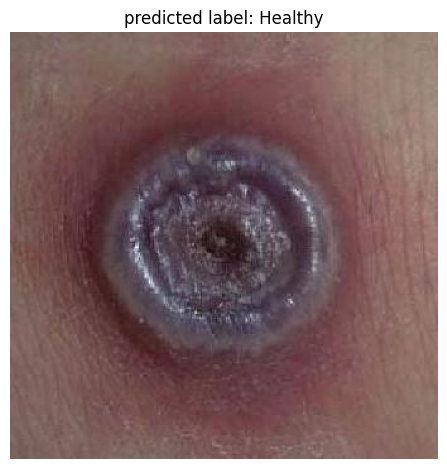

In [21]:
predict_label(img_path4)